# Exploring Skewness as a Measure of Interplanetary Scintillation
Code Author: Saf Flatters, Data Science CSIRO Intern from Curtin University

Supervisor: John Morgan, Space and Astronomy team 

Feburary 2025

-------------------------------------------
This code analyses MWA IPS GLEAM Survey radio source timeseries observations by calculating true skew values with a Signal to Noise Ratios (SNR) using linear interpolation for each observation (there are multiple observations per radio source). It produces multiple plots of each radio source to visualize the relationship between measured skew, true skew, SNR, elongation and modulation - with error bars. These plots also have lognormal and rice^2 shape models plotted for comparison against an Ordinary Least Squares Line of Best Fit and what I am calling Barlow's Weighted Non-linear Squares Line of Best fit (which takes into account variability of each observation and asymmetric errors). Each Radio Source has a Barlow's Reduced Chi Square value (using the BWNLS model). 
The code provides two exportable tables (Source_Table and Obs_Table) for further analysis.

## Method Description

1. Created a Lookup Table where every row has a SNR value, a sigma value and three sample skews (lower, median and upper percentiles) results uing a mixture distribution of Lognormal and Gaussian (Armstrong, 1971) 

2. Create a linear interpolation function for each SNR value linking the sigma values to the three sample skews (lower, median and upper) 

3. Import GLEAM timeseries and FITS data and calculate a measured skew, SNR and modulation *(cleaned data to avoid un-usable measured skews) 

4. For each observation, use 3 linear interpolation functions (lower, median and upper) for the closest SNR matching the SNR in the observation with an SNR in the lookup table and output 3 sigma values. *(cleaned data to avoid un-usable sigmas) 

5. Using sigmas found, calculated 3 true skew values (lower, median, upper) for each observation using a pure Lognormal distribution (no Gaussian as this an observations skew with noise removed) 

6. Clean and filter observation table for plotting 

7. Calculate Error Bars for each observation's True Skew using upper and lower true skew calculations to determine the variability of each observation

8. Generate theoretical Lognormal and $Rice^2$ Distribution Curves for Comparison with Radio Source Shape Curves

9. Fit a model to each radio source using Ordinary Least Squares (OLS), calculate scale variable and standard error of each curve and input results into observation table

10. Fit model to each source using Barlows-adapted Weighted Non-Linear Least Squares (BWNLS) and calculate Barlows Reduced $\chi^2$ for every observation and radio source as a whole. This model calculates best fit but incorporates weights for asymmetric errors (upper and lower) and gives less weight to observations with larger uncertainty. 

11. Using a Drop down menu sorted by NSI value of a Radio Source, the user can visualise each radio source on 6 plots. 
    - NSI being the well known unit of Normalised Scinitillation Index per source 

Plot 1: Elongation vs Modulation <- showing the trend we know a lot about before this study 
- Modulation being the unit of Scintillation Index per observation
- Elongation being distance from the sun in degrees

Plot 2: Elongation vs Measured Skew <- showing the measured skew from each timeseries observation plotted against elongation
- Measured skew being the skew (Armstrong's skew) of each observation timeseries of Flux over Time
- Dotted lines included to show the deviation between the plotted measured skew and the calculated true skew
- A regression line of best fit as been included in red

Plot 3: Elongation vs True Skew <- showing the true skew interpolated from measured skew (using a simulated sigma and SNR)
- True Skew represents a skew of each observation's timeseries once noise has been removed from measured skew
- Error bars derived from the Measured-to-True deconvolution process showing the level of variability of each observation

Plot 4: Elongation vs Signal to Noise <- showing SNR in relation to distance from the sun
- Signal to Noise being being the ratio of Signal to Noise. Calculated by the sqrt(variance of the source timeseries - variance of an offsource timeseries 5 pixels up and 5 pixels across from the same observation)/ standard deviation of that same offsource timeseries

Plot 5: Modulation vs Measured Skew <- showing the trend of measured skew in relation to their scintillation index (as per Armstrong, 1971 paper) to compare against theoretical distribution shape curves 
- A theoretical lognormal distribution shape curve is a blue line
- A theoretical rice^2 distribution shape curve is an orange line

Plot 6 (LARGE PLOT): Modulation vs True Skew <- showing the trend of the calculated True Skew in relation to their scintillation index 
- True Skew represents a skew of each observation's timeseries once noise has been removed from measured skew
- Error bars derived from the Measured-to-True deconvolution process showing the level of variability of each observation
- A theoretical lognormal distribution shape curve is a blue line
- A theoretical rice^2 distribution shape curve is an orange line
- A Ordinary Least Squares model line is the purple line showing line of best fit taking into account median true skew (observation points only)
- A Barlows Adapted Weighted Non-linear Squares model line is the pink line showing line of best fit taking into account each observations asymmetric error bars and weighting towards observations with smaller errors (less variability) - chi square calculation for this model is included in the subplot legend. 

Note: Observations plotted with grey X's are observations are low skew outliers (that created issues with interpolating True Skew from Measured Skew)

Note: Observations represented by a Grey circle are observations with a Signal to Noise less than 1

12. Created 2 Tables for export - Source_Table and Obs_Table

13. APPENDICES

- a) SNR influence on skew
- b) SNR to Sigma Confidence Intervals
- c) Plot of Sigma Values
- d) Small Skew Monte Carlo
- e) Chi^2 Histogram
- f) NSI vs Barlows Scaled Variable (skew scale)
- g) NSI vs OLS Scaled Variable (coloured by standard errors)

## Imports and Files

Saf's docs:
- Gleam_Skewness.ipynb <- (this code file)
- README 
- environment.yml
- requirements.txt

Data: 
- ips/timeseries_full.hdf5 <- a large set of timeseries from the GLEAM survey (both radio sources and offsources)
        (note: timeseries_full.hdf5 is 105MB and therefore not on the repository... see John Morgan for data)
- ssh_to_local.ipynb <-  how I downloaded the large set of timeseries (on and offsource) from the MWA Image Cube. 

Code from others to extract data:
- ips/bright_source_background.vot
- add_ps_fit_params_to_table.py
- bright_cat_pf.fits
- hdf5_to_tables.ipynb
- imstack.py


In [54]:
# For importing Astro data
import h5py
from tqdm import tqdm

# For tables, arrays and plotting
import os
import numpy as np
from astropy.table import Table, Column
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

# For plotting with widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# Statistics specific
import scipy as sc
from scipy import stats
from scipy.stats import skew, rice, lognorm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import chi2

# For Data Cleaning
from collections import Counter

# Ignore warnings during imports
import warnings
warnings.filterwarnings('ignore')

#Other code
from imstack import ImageStack

In [55]:
# For creating and adding to Astropy Tables
def add_table_col(table_name, col_name, col_to_add, description_string):
    table_name[col_name] = Column(col_to_add, description= description_string)

# Tables created in this project (# * asterixes in column names mean values in column have been calculated, not from raw_table import)
#1.
lognormal_lookup_Table = Table()

#2. 
# raw_table > calculated_table > sigmas_found_table > threetrue_table > ThreeTrue_filt > Obs_Table

#3. 
# Source_Table

## Create a Lookup Table 
For Signal-to-Noise (SNR) values ranging from 0.3 to 50 inside a range sigma values between 0 and 1.

Used Monte Carlo to generate 10000 draws inside 520 samples from:

- A lognormal distribution (representing true measurements).

- A Gaussian distribution (representing noise).

Combine samples for a mixture distribution to simulate measurements collected from timeseries data.

Calculate the skew of each combined sample

Store the median, lower, and upper percentiles with each sigma and SNR in Lookup Table.

In [56]:
#Create simulated sigma values (Shape parameter for Lognormal Dist.) -  Between 0 and 1 including 1. 
row_sigma = np.hstack(([0.0], np.logspace(-2, -1, 10, endpoint=False), np.linspace(0.1, 1, 30)))

#Create SNR column for adding noise 
SN_ratios = [0.3, 0.5, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 10, 50]


#Monte Carlo samples and draws
n_samples = 520 # Number of samples 
n_draws = 1000  # Number of Monte Carlo draws

#Lookup tables to have sigma, SNR, meas_skew_lowerp, meas_skew_medp, meas_skew_upperp
sigma_col = []
SNR_col = []
meas_skew_lowerp_col = []
meas_skew_medp_col = []
meas_skew_upperp_col = []

#Create a distribution for each simulated sigma and SNR and collect measured skew percentiles (520 samples, 10000 monte carlo draws
for sigma in row_sigma:
    for SNR in SN_ratios:
        if sigma==0.0:
                sigma_col.append(sigma)
                SNR_col.append(SNR)
                meas_skew_lowerp_col.append(0.0)
                meas_skew_medp_col.append(0.0)
                meas_skew_upperp_col.append(0.0)
                continue

# Generate Monte Carlo lognormal samples for the each sigma (520 samples, 10000 Monte Carlo draws)
        log_samples = lognorm.rvs(sigma, size=(n_samples, n_draws))         #520r x 10000c matrix of random numbers from lognorm dist using sigma for each row in lognormal table

# Calculate var, std for each sigma       
        var_ = lognorm.stats(sigma, moments = 'v')
        std_ = np.sqrt(var_)

# Generate Monte Carlo gaussian samples for the each sigma and SNR (520 samples, 10000 Monte Carlo draws)
        noise_samples = np.random.normal(0, size=(n_samples, n_draws), scale=std_ / SNR) 

# Calculate samples for each sigma and SNR that are Lognormal + Gaussian (520 samples, 10000 Monte Carlo draws)
        comb_samples = log_samples + noise_samples

# Calculate skew of combined (measured) samples (shape = 1 row, 10000 columns)
        meas_skew_samples = skew(comb_samples, axis=0)**2/4
        
# Calculate percentiles for skew of combined (measured) samples (shape = 1 row, 3 columns) - Using the 68% gaussian rule
        meas_skew_lowerp, meas_skew_medp, meas_skew_upperp = np.percentile(meas_skew_samples, (100/6., 300/6., 500/6.))

# Append data to lists
        sigma_col.append(sigma)
        SNR_col.append(SNR)
        meas_skew_lowerp_col.append(meas_skew_lowerp)
        meas_skew_medp_col.append(meas_skew_medp)
        meas_skew_upperp_col.append(meas_skew_upperp)

# Add lognormal simulated columns to a table
add_table_col(lognormal_lookup_Table, 'sigma', sigma_col, 'Simulated sigma values (scale parameter)')
add_table_col(lognormal_lookup_Table, 'SNR', SNR_col, 'Signal-to-Noise ratio')
add_table_col(lognormal_lookup_Table, 'sample_skew_lower', meas_skew_lowerp_col, 'log+gauss skew 16.67 percentile')
add_table_col(lognormal_lookup_Table, 'sample_skew_med', meas_skew_medp_col, 'log+gauss skew 50 percentile')
add_table_col(lognormal_lookup_Table, 'sample_skew_upper', meas_skew_upperp_col, 'log+gauss skew 83.33 percentile')

In [57]:
# Lookup Table output
lognormal_lookup_Table[120:123]

sigma,SNR,sample_skew_lower,sample_skew_med,sample_skew_upper
float64,float64,float64,float64,float64
0.039810717055349734,0.5,0.00012641212577840704,0.0013620914117678138,0.00548002106020661
0.039810717055349734,0.8,0.00011188175960260753,0.0012503714844704684,0.006129380231957158
0.039810717055349734,1.0,0.000135559470805144,0.0015156831212042366,0.006066925086461499


### Linear Interpolation between sigma and sample skews in Lookup Table
For each SNR value in the lookup table, create linear interpolation functions to link a sigma value to the corresponding median, upper, and lower sample skew values.

In [58]:
# Dictionary to store interpolation functions for each SNR
interpolation_functions = {}

# Loop through each SNR
for snr in SN_ratios:
    log_sigma_med = []
    log_skew_med = []
    log_sigma_lower = []
    log_skew_lower = []
    log_sigma_upper = [] 
    log_skew_upper = []  

    # Collect data for the current SNR
    for row in lognormal_lookup_Table:
        if snr == row["SNR"]:
            # Data for median interpolation
            log_sigma_med.append(row["sigma"])
            log_skew_med.append(row["sample_skew_med"])
            
            # Data for lower interpolation
            log_sigma_lower.append(row["sigma"])
            log_skew_lower.append(row["sample_skew_lower"])
            
            # Data for upper interpolation
            log_sigma_upper.append(row["sigma"])
            log_skew_upper.append(row["sample_skew_upper"])

    # Sort the data to ensure x values are increasing for interpolation
    sorted_indices_med = sorted(range(len(log_skew_med)), key=lambda k: log_skew_med[k])
    log_skew_med_sorted = [log_skew_med[i] for i in sorted_indices_med]
    log_sigma_med_sorted = [log_sigma_med[i] for i in sorted_indices_med]

    sorted_indices_lower = sorted(range(len(log_skew_lower)), key=lambda k: log_skew_lower[k])
    log_skew_lower_sorted = [log_skew_lower[i] for i in sorted_indices_lower]
    log_sigma_lower_sorted = [log_sigma_lower[i] for i in sorted_indices_lower]

    sorted_indices_upper = sorted(range(len(log_skew_upper)), key=lambda k: log_skew_upper[k])
    log_skew_upper_sorted = [log_skew_upper[i] for i in sorted_indices_upper]
    log_sigma_upper_sorted = [log_sigma_upper[i] for i in sorted_indices_upper]

    # Create interpolation functions for the current SNR
    interp_med = interp1d(log_skew_med_sorted, log_sigma_med_sorted, kind='linear', fill_value="extrapolate")
    interp_lower = interp1d(log_skew_lower_sorted, log_sigma_lower_sorted, kind='linear', fill_value="extrapolate")
    interp_upper = interp1d(log_skew_upper_sorted, log_sigma_upper_sorted, kind='linear', fill_value="extrapolate")

    # Store the interpolation functions in the dictionary
    interpolation_functions[snr] = {
        'interp_med': interp_med,
        'interp_lower': interp_lower,
        'interp_upper': interp_upper
    }

## GLEAM Survey

### Import Timeseries and Table Data 

In [59]:
# Read in Data
raw_table = Table.read('bright_cat_pf.fits', format='fits')

with h5py.File("../ips/timeseries_full.hdf5", "r") as f:
    # Access the datasets
    onsource_ts = f["on_source"][...]
    offsource_ts = f["off_source"][...]
    h5_isvalid = f["is_valid"][...]

### Calculate Measured Skew, SNR and Modulation of sources from GLEAM survey
Import GLEAM timeseries and FITS table and calculate a measured skew, SNR and modulation (clean data to avoid un-usable measured skews)


In [60]:
# find the maximum in lookup table to ensure real data is represented in lookup Table
sample_skew_upper_max = lognormal_lookup_Table['sample_skew_upper'].max()

# store new calculations before added to table
calculated_data = []

#For each table row (observation) in chosen candidates
for i, table_row in tqdm(enumerate(raw_table), total=len(raw_table)):

    try:        
        #Calculate modulation 
        modulation = table_row['nsi1'] * table_row['mpt1']

        # Calculate measured skew
        raw_mean = np.mean(onsource_ts[i])
        onsource_ts[i] = onsource_ts[i] - raw_mean + table_row['peak_flux']  #remove normalisation in GLEAM survey done by JMorgan
        meas_skew = (skew(onsource_ts[i])**2)/4 # Armstrong, 1971's version of skew

        # Calculate Scipy's skew
        classic_skew = skew(onsource_ts[i])

        # Boolean to ensure lookup table is representative of actual data
        if meas_skew < sample_skew_upper_max:
            skew_in_range = True
        else: 
            skew_in_range = False

        # Import noise data for each radio source measurement (5 pixels up and across) and calculate SNR
        noise_std = np.std(offsource_ts[i])
        signal_std = np.sqrt(np.var(onsource_ts[i])) - np.var(offsource_ts[i])
        SNR_source = signal_std/noise_std

            #Add new statistics with existing data         
        calculated_data.append(list(table_row) + [modulation, meas_skew, classic_skew, SNR_source, skew_in_range])

    except Exception as error:
        print(f'Error procession ObsID {table_row['obsid']}: {error}')
        continue

#Make new table with existing data and new statistics calculated 
new_col_names = list(raw_table.colnames) + ['Modulation*', 'meas_skew*', 'classic_skew*', 'SNR_source*', 'skew_in_range*']
calculated_table = Table(rows=calculated_data, names=new_col_names)

#Change order of columns for easy viewing
desired_column_order = ['GLEAM', 'obsid', 'meas_skew*', 'classic_skew*', 'SNR_source*', 'elongation2', 'Modulation*', 'skew_in_range*', 'peak_flux', 'nsi1', 'mpt1', 'nsi_fit', 's_162',]
other_columns = [col for col in calculated_table.colnames if col not in desired_column_order]
new_column_order = desired_column_order + other_columns
calculated_table = calculated_table[new_column_order]

calculated_table = calculated_table[desired_column_order]

100%|██████████| 22573/22573 [00:20<00:00, 1088.21it/s]


In [61]:
# Determine any observations outside lookup table range (where easured skew is infinity, nan or over 8...)
out_of_range = sum(~calculated_table['skew_in_range*'])
print(f"Number of observations outside simulated skew range: {out_of_range}")

# Uncomment to see observations outside range
# false_rows = calculated_table[~calculated_table['skew_in_range*']]
# selected_columns = ['GLEAM', 'obsid', 'meas_skew*', 'SNR_source*']
# false_rows[selected_columns]

# Remove observations outside range
print(f"Number of Observations: {len(calculated_table)}, Number of Radio Sources: {len(set(calculated_table['GLEAM']))}")
calculated_table = calculated_table[calculated_table['skew_in_range*']]
print(f"Number of Observations after removing sources outside simulated skew range: {len(calculated_table)}, Number of Radio Sources: {len(set(calculated_table['GLEAM']))}")

# Remove 'skew_in_range*' column from calculated_table
calculated_table.remove_column('skew_in_range*')

Number of observations outside simulated skew range: 57
Number of Observations: 22573, Number of Radio Sources: 885
Number of Observations after removing sources outside simulated skew range: 22516, Number of Radio Sources: 885


In [62]:
# Calculated Table output
calculated_table[:3]

GLEAM,obsid,meas_skew*,classic_skew*,SNR_source*,elongation2,Modulation*,peak_flux,nsi1,mpt1,nsi_fit,s_162
str14,int64,float64,float64,float16,float32,float64,float32,float64,float64,float32,float32
J000106-174125,1233384720,0.0018123770132660866,0.08514404296875,1.199,40.05951,0.15238475799560547,0.51282907,0.6738725900650024,0.22613288462162018,0.84610957,1.2137686
J000106-174125,1233472808,0.016806185245513916,0.25927734375,1.402,39.131214,0.1552976667881012,0.60092515,0.6655634045600891,0.23333263397216797,0.84610957,1.2137686
J000106-174125,1233559208,0.0034834779798984528,0.1180419921875,1.457,38.225433,0.15429046750068665,0.63318574,0.6406790614128113,0.24082332849502563,0.84610957,1.2137686


### Find 3 sigmas for each observation in data using Interpolation
For each observation:

- extract it's measured skew from created_table (real data)

- calculated closest SNR in lookup table using SNR in created_table (real data)

- use 3x linear interpolation functions (lower, med, upper) for specified SNR - input 1x measured skew - outputs 3x sigmas

Clean any observations with sigmas greater than 1

In [63]:
# store data calculated in lists
lower_sigma = []
med_sigma = []
upper_sigma = []
nearest_SNR = []

# Loop through rows in the table
for row in calculated_table:

    # Find the closest SNR
    closest_snr = min(SN_ratios, key=lambda x: abs(x - row["SNR_source*"]))
    nearest_SNR.append(closest_snr)

    # Get interpolation functions for the closest SNR
    interp_functions = interpolation_functions.get(closest_snr, None)

    if interp_functions:
        # Use the interpolation functions to predict sigma
        try:
            predicted_lower_sigma = float(interp_functions['interp_lower'](row["meas_skew*"]))
            lower_sigma.append(predicted_lower_sigma)
        except ValueError:
            print(f"Warning: Invalid interpolation for measured skew = {row["meas_skew*"]} and SNR = {closest_snr}")
            lower_sigma.append(None)

        try:
            predicted_med_sigma = float(interp_functions['interp_med'](row["meas_skew*"]))
            med_sigma.append(predicted_med_sigma)
        except ValueError:
            print(f"Warning: Invalid interpolation for measured skew = {row["meas_skew*"]} and SNR = {closest_snr}")
            med_sigma.append(None)

        try:
            predicted_upper_sigma = float(interp_functions['interp_upper'](row["meas_skew*"]))
            upper_sigma.append(predicted_upper_sigma)
        except ValueError:
            print(f"Warning: Invalid interpolation for measured skew = {row["meas_skew*"]} and SNR = {closest_snr}")
            upper_sigma.append(None)
    else:
        print(f"Warning: No interpolation functions found for SNR = {closest_snr}")
        lower_sigma.append(None)
        med_sigma.append(None)
        upper_sigma.append(None)

# Add columns to the Calculated table
add_table_col(calculated_table, 'lower sigma*', lower_sigma, 'lower sigma')
add_table_col(calculated_table, 'med sigma*', med_sigma, 'med sigma')
add_table_col(calculated_table, 'upper sigma*', upper_sigma, 'upper sigma')
add_table_col(calculated_table, 'closest SNR*', nearest_SNR, 'snr nearest neighbour to lookup')

# Change order of columns for easier viewing
desired_column_order = ['GLEAM', 'obsid', 'meas_skew*', 'SNR_source*', 'closest SNR*', 'lower sigma*', 
                        'med sigma*', 'upper sigma*', 'Modulation*', 'elongation2', 
                         'nsi_fit', 's_162', 'peak_flux', 'nsi1', 'mpt1']
other_columns = [col for col in calculated_table.colnames if col not in desired_column_order]
new_column_order = desired_column_order + other_columns

# Table renamed to sigmas_found_table
sigmas_found_table = calculated_table[new_column_order]

In [64]:
# Remove rows where any of the sigma columns have a value > 1
print(f"Number of Observations: {len(sigmas_found_table)}, Number of Radio Sources: {len(set(sigmas_found_table['GLEAM']))}")
sigma_found_before_del = sigmas_found_table
sigmas_found_table = sigmas_found_table[~(
    (sigmas_found_table['lower sigma*'] > 1) |
    (sigmas_found_table['med sigma*'] > 1) |
    (sigmas_found_table['upper sigma*'] > 1)
)]
print(f"Number of Observations after removing sources with any sigmas above 1: {len(sigmas_found_table)}, Number of Radio Sources: {len(set(sigmas_found_table['GLEAM']))}")

Number of Observations: 22516, Number of Radio Sources: 885
Number of Observations after removing sources with any sigmas above 1: 22493, Number of Radio Sources: 884


In [65]:
# Sigmas found table output
sigmas_found_table[:3]

GLEAM,obsid,meas_skew*,SNR_source*,closest SNR*,lower sigma*,med sigma*,upper sigma*,Modulation*,elongation2,nsi_fit,s_162,peak_flux,nsi1,mpt1,classic_skew*
str14,int64,float64,float16,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64
J000106-174125,1233384720,0.0018123770132660866,1.199,1.2,0.1395439616348377,0.04412704851975687,0.0034376524287465984,0.15238475799560547,40.05951,0.84610957,1.2137686,0.51282907,0.6738725900650024,0.22613288462162018,0.08514404296875
J000106-174125,1233472808,0.016806185245513916,1.402,1.4,0.23469723098576864,0.16575988281925041,0.09358237719634804,0.1552976667881012,39.131214,0.84610957,1.2137686,0.60092515,0.6655634045600891,0.23333263397216797,0.25927734375
J000106-174125,1233559208,0.0034834779798984528,1.457,1.4,0.145211541411988,0.07516959677806506,0.008230201620410762,0.15429046750068665,38.225433,0.84610957,1.2137686,0.63318574,0.6406790614128113,0.24082332849502563,0.1180419921875


### Calculate 3 True Skews using Sigmas
Using 3 sigmas found, calculated 3 true skew values (lower, median, upper) for each observation using a pure Lognormal distribution (no Gaussian as this an observations skew with noise removed)

Note: The lower true skew corresponds to the upper sigma because a higher sigma value produces a smaller skew value, reflecting the smallest plausible true skew. Same for upper true skew corresponding to lower sigma (see appendices)

In [66]:
lower_tskew = []
med_tskew = []
upper_tskew = []

for row in sigmas_found_table:
    lower_tskew.append(lognorm.stats(row['upper sigma*'], moments = 's')**2/4)      
    med_tskew.append(lognorm.stats(row['med sigma*'], moments = 's')**2/4)
    upper_tskew.append(lognorm.stats(row['lower sigma*'], moments = 's')**2/4)

# Add columns to data table
add_table_col(sigmas_found_table, 'lower true skew*', lower_tskew, 'lower error of true skew 16.67 percentile')
add_table_col(sigmas_found_table, 'median true skew*', med_tskew, 'true skew')
add_table_col(sigmas_found_table, 'upper true skew*', upper_tskew, 'upper error of true skew 83.33 percentile')

#Change order of columns for easy viewing
desired_column_order = ['GLEAM', 'obsid', 'meas_skew*', 'SNR_source*', 'lower true skew*', 
                        'median true skew*', 'upper true skew*', 'Modulation*', 'elongation2', 
                        'peak_flux', 'nsi1', 'mpt1', 'nsi_fit', 's_162']
other_columns = [col for col in sigmas_found_table.colnames if col not in desired_column_order]
new_column_order = desired_column_order + other_columns
threetrue_table = sigmas_found_table[new_column_order]

In [67]:
# Threetrue Table output
threetrue_table[:3]

GLEAM,obsid,meas_skew*,SNR_source*,lower true skew*,median true skew*,upper true skew*,Modulation*,elongation2,peak_flux,nsi1,mpt1,nsi_fit,s_162,closest SNR*,lower sigma*,med sigma*,upper sigma*,classic_skew*
str14,int64,float64,float16,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64
J000106-174125,1233384720,0.0018123770132660866,1.199,2.6589638587718372e-05,0.004391160514369987,0.04482439372578844,0.15238475799560547,40.05951,0.51282907,0.6738725900650024,0.22613288462162018,0.84610957,1.2137686,1.2,0.1395439616348377,0.04412704851975687,0.0034376524287465984,0.08514404296875
J000106-174125,1233472808,0.016806185245513916,1.402,0.019907501900021794,0.06384836027100985,0.13226871014858935,0.1552976667881012,39.131214,0.60092515,0.6655634045600891,0.23333263397216797,0.84610957,1.2137686,1.4,0.23469723098576864,0.16575988281925041,0.09358237719634804,0.25927734375
J000106-174125,1233559208,0.0034834779798984528,1.457,0.00015241853677642436,0.012797748821619244,0.04863174288014294,0.15429046750068665,38.225433,0.63318574,0.6406790614128113,0.24082332849502563,0.84610957,1.2137686,1.4,0.145211541411988,0.07516959677806506,0.008230201620410762,0.1180419921875


### Clean and Filter table for plotting
- Removed observations with NaN, inf, negatives in in Modulation*, meas_skew*, SNR_source*, med true skew*, upper true skew*, lower true skew*
- Removed observations that have a classic skew of less than 0.21445500809190127 (see appendices) and make small_skews_table to plot these as crosses on plots
- Removed sources with less than 10 observations 

In [68]:
# change table name to allow access to pre-filtered table
ThreeTrue_filt = threetrue_table

In [69]:
# Function to clean up observations and keep track of what was cleaned
def clean_and_track_removals(table, column_name):
    initial_count = len(table)
    table[column_name] = np.asarray(table[column_name], dtype='float')
# Remove NaN values
    table = table[~np.isnan(table[column_name])]
    removed_nan = initial_count - len(table)
# Remove Inf values
    initial_count = len(table)
    table = table[~np.isinf(table[column_name])]
    removed_inf = initial_count - len(table)
# Remove negative values
    initial_count = len(table)
    table = table[table[column_name] >= 0]
    removed_negative = initial_count - len(table)
# Removal statistics
    removal_stats = {
        'removed_nan': removed_nan,
        'removed_inf': removed_inf,
        'removed_negative': removed_negative
    }
    
    return table, removal_stats


In [70]:
# Observations to be removed by clean_and_track_removals function if select columns are inf, NaN or negative 
columns_to_clean = [
    'Modulation*', 
    'meas_skew*', 
    'lower true skew*', 
    'median true skew*', 
    'upper true skew*', 
    'SNR_source*'
]
removal_summary = {}

for column in columns_to_clean:
    ThreeTrue_filt, stats_ = clean_and_track_removals(ThreeTrue_filt, column)
    removal_summary[column] = stats_
    print(f"\nColumn: '{column}':"
          f"\n {stats_['removed_nan']} observations removed (NaN) "
          f"\n {stats_['removed_inf']} observations removed (Inf) "
          f"\n {stats_['removed_negative']} observations removed (Negative values)")



Column: 'Modulation*':
 0 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)

Column: 'meas_skew*':
 0 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)

Column: 'lower true skew*':
 1 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)

Column: 'median true skew*':
 0 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)

Column: 'upper true skew*':
 0 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)

Column: 'SNR_source*':
 0 observations removed (NaN) 
 0 observations removed (Inf) 
 0 observations removed (Negative values)


In [71]:
# REMOVE observations that have a classic skew of less than 0.21445500809190127 

second_std = (ThreeTrue_filt['classic_skew*'] < 0.21445500809190127).sum()  #number found - see appendices for reason
print(f"Number of observations less than 2 std (found in Placebo Check) = {second_std} ({second_std/len(ThreeTrue_filt)*100:.2f}%)")

# make small_skews_table so can still be plotted on plots as x's
small_skews_table = ThreeTrue_filt[ThreeTrue_filt['classic_skew*'] < 0.21445500809190127]

print(f"Number of Observations: {len(ThreeTrue_filt)}, Number of Radio Sources: {len(set(ThreeTrue_filt['GLEAM']))}")
ThreeTrue_filt = ThreeTrue_filt[ThreeTrue_filt['classic_skew*'] > 0.21445500809190127]
print(f"After removing obs < 0.21445500809190127 Number of Observations: {len(ThreeTrue_filt)}, Number of Radio Sources: {len(set(ThreeTrue_filt['GLEAM']))}")


Number of observations less than 2 std (found in Placebo Check) = 6397 (28.44%)
Number of Observations: 22492, Number of Radio Sources: 884
After removing obs < 0.21445500809190127 Number of Observations: 16095, Number of Radio Sources: 826


In [72]:
# Remove observations where the radio sources have less than 10 observations: 

# Count occurrences of each GLEAM value
gleam_counts = Counter(ThreeTrue_filt['GLEAM'])

# Filter the rows that have GLEAM appearing at least 10 times
ThreeTrue_filt = ThreeTrue_filt[[gleam_counts[gleam] >= 10 for gleam in ThreeTrue_filt['GLEAM']]]

print(f"Number of Observations: {len(ThreeTrue_filt)}, Number of Radio Sources: {len(set(ThreeTrue_filt['GLEAM']))}")
print(f"Number of Observations after removing sources with less than 10 observations: {len(ThreeTrue_filt)}, Number of Radio Sources: {len(set(ThreeTrue_filt['GLEAM']))}")

Number of Observations: 15135, Number of Radio Sources: 616
Number of Observations after removing sources with less than 10 observations: 15135, Number of Radio Sources: 616


In [73]:
# Check and store min and max of relevant columns
# Compute min and max values for axis limits
elon_min = ThreeTrue_filt["elongation2"].min()
elon_max = ThreeTrue_filt["elongation2"].max()

mod_min = ThreeTrue_filt["Modulation*"].min()
mod_max = ThreeTrue_filt["Modulation*"].max()

skew_min = ThreeTrue_filt["meas_skew*"].min()
skew_max = ThreeTrue_filt["meas_skew*"].max()

ltskew_min = ThreeTrue_filt["lower true skew*"].min()
ltskew_max = ThreeTrue_filt["lower true skew*"].max()

mtskew_min = ThreeTrue_filt["lower true skew*"].min()
mtskew_max = ThreeTrue_filt["lower true skew*"].max()

utskew_min = ThreeTrue_filt["upper true skew*"].min()
utskew_max = ThreeTrue_filt["upper true skew*"].max()

SNR_min = ThreeTrue_filt["SNR_source*"].min()
SNR_max = ThreeTrue_filt["SNR_source*"].max()


# Print min and max values for axis limits
print(f"Elongation2: min = {elon_min}, max = {elon_max}")
print(f"Modulation*: min = {mod_min}, max = {mod_max}")
print(f"Measured Skew*: min = {skew_min}, max = {skew_max}")
print(f"lower true skew*: min = {ltskew_min}, max = {ltskew_max}")
print(f"median true skew*: min = {mtskew_min}, max = {mtskew_max}")
print(f"upper true skew*: min = {utskew_min}, max = {utskew_max}")
print(f"SNR Source*: min = {SNR_min}, max = {SNR_max}")

Elongation2: min = 12.044726371765137, max = 53.63887405395508
Modulation*: min = 0.0, max = 0.9311135411262512
Measured Skew*: min = 0.011513248085975647, max = 1.890625
lower true skew*: min = 0.002699281110108638, max = 1.656608963171647
median true skew*: min = 0.002699281110108638, max = 1.656608963171647
upper true skew*: min = 0.02835759406820693, max = 8.9884658604087
SNR Source*: min = 0.669921875, max = 49.34375


### Calculate Error bars 
Calculate Error Bars for each observation's True Skew using upper and lower true skew calculations 

These error bars may be assymetric and represent the variability of each observation

In [74]:
lower_errors = []
upper_errors = []

#calculate errors for each row and put into lists
for row in ThreeTrue_filt:
    lower_err = row['median true skew*'] - row['lower true skew*']  # Lower bound (50% - 16%)
    upper_err = row['upper true skew*'] - row['median true skew*']  # Upper bound (83% - 50%)
    lower_errors.append(lower_err)
    upper_errors.append(upper_err)

# Add columns to table
add_table_col(ThreeTrue_filt, 'lower skew error*', lower_errors, 'Error bar(50 - 16)')
add_table_col(ThreeTrue_filt, 'upper skew error*', upper_errors, 'Error bar(83 - 50)')

# Check error bars (they can not be negative!)
neg_low_error = sum(ThreeTrue_filt['lower skew error*'] < 0)
print(f"Number of observations with negative lower skew error: {neg_low_error} out of {len(ThreeTrue_filt)}")
ThreeTrue_filt = ThreeTrue_filt[ThreeTrue_filt['lower skew error*'] >= 0]

neg_upp_error = sum(ThreeTrue_filt['upper skew error*'] < 0)
print(f"Number of observations with negative upper skew error: {neg_upp_error} out of {len(ThreeTrue_filt)}")
ThreeTrue_filt = ThreeTrue_filt[ThreeTrue_filt['upper skew error*'] >= 0]

print(f"\nNumber of Observations after removing sources with negative error bars: {len(ThreeTrue_filt)}, Number of Radio Sources: {len(set(ThreeTrue_filt['GLEAM']))}")

Number of observations with negative lower skew error: 0 out of 15135
Number of observations with negative upper skew error: 0 out of 15135

Number of Observations after removing sources with negative error bars: 15135, Number of Radio Sources: 616


## Fitting Models between Median True Skew and Modulation

### Generate theoretical Lognormal and $Rice^2$ distribution shape curves 
These are theoretical distribution shaped curves to be plotted for comparison with radio source specific shape curves 

Note: The lognormal curve uses the ThreeTrue_filt Modulation (the plot's x-axis) maximum as a parameter so this may change with changes to the table or the x-axis

In [75]:
# Functions to build theoretical distribution shaped curves: 

def lognorm_curve(max_):
    scale_values = np.linspace(0.001, max_, 100) # max is x axis max 
# Calculate moments from lognorm distribution using s as sigma
    mean_lognorm_stats, var_lognorm_stats, skew_lognorm_stats = lognorm.stats(scale_values, moments='mvs')
# Calculate ratio of the standard deviation to the mean for the log-normal distribution
    lognorm_mean_to_var_ratio = np.sqrt(var_lognorm_stats)/mean_lognorm_stats
# Calculate squared skewness for the log-normal distribution
    lognorm_skew_squared = skew_lognorm_stats**2/4

    return lognorm_mean_to_var_ratio, lognorm_skew_squared  #this is what you need to build a curve


def rice2_curve():
    b_vals = 20/np.linspace(0.001, 20, 19)
    N=100000
    rice2_mean_to_var_ratio = np.zeros_like(b_vals)
    skew_rice2 =  np.zeros_like(b_vals)
    for i, b in enumerate(b_vals):
        x = rice.rvs(b, size=N)**2
        rice2_mean_to_var_ratio[i] = np.std(x)/np.mean(x)
        skew_rice2[i] = skew(x)
    rice2_skew_squared = skew_rice2**2/4

    return rice2_mean_to_var_ratio, rice2_skew_squared

In [76]:
# Create lognorm and rice**2 curve
lognorm_mean_to_var_ratio, lognorm_skew_squared = lognorm_curve(mod_max)
rice2_mean_to_var_ratio, rice2_skew_squared = rice2_curve()


#Example on how to use in a plot:
# fig, axes = plt.subplots()
# axes.plot(lognorm_mean_to_var_ratio, lognorm_skew_squared, label='lognorm', color="blue", alpha=0.3)
# axes.plot(rice2_mean_to_var_ratio, rice2_skew_squared, label='rice$^2$', color="orange", alpha=0.3)

### Fit model to each radio source using Ordinary Least Squares (OLS) 
This model's goal is to produce a curve of Best Fit: OLS ensures that the fitted model as close as possible to the observations by reducing the overall error.
This does not take into account individual error bars (individual observation variability) - Assumes errors are symmetric and homoscedastic.

Using scipy's curve_fit returns a scale variable and a covariance matrix.
Scaled variable is part of the equation to build a curve (used in the actual plotting code)
Square-rooting the covariance matrix results in the standard error of this model. 

In [77]:
# Functions to build Lognormal model and curve using Ordinary Least Squares 

def fit_lognorm(x, scale_variable):

    return fitted_lognorm_curve(x, scale_variable)


class LognormInterp:
    def __init__(self, max_, n_step):
        s = np.linspace(0.001, max_, n_step) # max is x axis max    
        mean_lognorm_stats, var_lognorm_stats, skew_lognorm_stats = lognorm.stats(s, moments='mvs')
        self.m_lognorm_stats = np.sqrt(var_lognorm_stats)/mean_lognorm_stats
        self.armstrong_skew_lognorm = skew_lognorm_stats**2/4

    def __call__(self, ms):

        return np.interp(ms, self.m_lognorm_stats, self.armstrong_skew_lognorm)


def lognorm_curve(max_):
    s = np.linspace(0.001, max_, 100) # max is x axis max    
    mean_lognorm_stats, var_lognorm_stats, skew_lognorm_stats = lognorm.stats(s, moments='mvs')
    m_lognorm_stats = np.sqrt(var_lognorm_stats)/mean_lognorm_stats
    armstrong_skew_lognorm = skew_lognorm_stats**2/4

    return m_lognorm_stats, armstrong_skew_lognorm


def fitted_lognorm_curve(m_array, skew_scale):
    linterp = LognormInterp(10, 100)

    return skew_scale*linterp(m_array)

In [78]:
# Ordinary Least Squares scaled variable and standard error for each radio source

# Lists to store results
OLS_scaled_var_by_source = []
OLS_scaled_var_by_source_for_all = []
OLS_std_error = []

ThreeTrue_filt_grouped = ThreeTrue_filt.group_by('GLEAM')

# For each GLEAM radio source:
for source in ThreeTrue_filt_grouped.groups:
    OLS_scale_variable, OLS_covariance = sc.optimize.curve_fit(fit_lognorm, source['Modulation*'], source['median true skew*'], p0=[1]) #p0 is initial guess
    OLS_scaled_var_by_source.append(OLS_scale_variable) # scaled variable per radio source

    # scaled variable per radio source multiplied by number of obs per source for obs table row 
    OLS_scaled_var_by_source_for_all.extend([OLS_scale_variable] * len(source)) 

    # sqrt of covariance matrix diagonol per radio source multiplied by number of obs per source for obs table row
    standard_error = np.sqrt(np.diag(OLS_covariance))[0]
    OLS_std_error.extend([standard_error] * len(source))

# add the results for the radio source to all of it's observations 
# p.s in the column name means 'per source' - alluding to the value will be the same for all obs for that source
add_table_col(ThreeTrue_filt, 'OLS scaled variable p.s*', OLS_scaled_var_by_source_for_all, 'OLS scaled variable using curve fit')
add_table_col(ThreeTrue_filt, 'OLS std error p.s*', OLS_std_error, 'OLS std error using curve fit')

# # example of usage in plotting
# scaled_curve = fitted_lognorm_curve(source['Modulation*'], source['OLS scaled variable p.s*'][0])
# #Extended for plotting past the highest point
# extended_modulation = np.linspace(0.01, np.max(source['Modulation*'])+1, 1000)
# extended_scaled_curve = fitted_lognorm_curve(extended_modulation, source['OLS scaled variable p.s*'][0])

# axes.plot(extended_modulation, extended_scaled_curve, label=f'OLS fitted lognorm curve', color='purple')

### Fit model to each source using Barlows-adapted Weighted Non-Linear Least Squares (BWNLS) 
This model calculates best fit but incorporates weights for asymmetric errors (upper and lower) and gives less weight to observations with larger uncertainty. This approach falls under the broader category of Generalised Least Squares (GLM).

For code - see '### Calculate Chi^2 between Obs and Barlows Reduced Chi Squared model' below as this is done in the same loop as calculating the chi^2. 

### Calculate Chi^2 for each obs and for each source
1. Between observations and Pink line which I'm calling BWNLS - Barlows Weighted Non-linear Least Squares (accounts for asymmetric errors and gives less weight to larger uncertainty)

2. Between observations and Purple line called OLS - Ordinary Least Squares (assumes errors are symmetric and have constant variance)

3. Between observations and Blue line which is the Theoretical Lognormal Shape Curve  

4. Between observations and Orange line which is the Theoretical Rice Squared Shape Curve

* Note: As 24/2/2025 only chi^2 model calculation performed is 1.


#### Calculate Chi^2 between Obs and Barlows Reduced Chi Squared model
(Barlow, 2003)
$$\text{Barlows Reduced} ~\chi^2 = (\frac{\delta}{\sigma})^2 (1 - 2A(\frac{\delta}{\sigma})+ 5A^2(\frac{\delta}{\sigma})^2)$$

In [79]:
def barlows_red_chisq(y_obs, y_model, lower_e, upper_e):
# Calculate delta (difference between observation and model)
    delta = y_obs - y_model
# Compute symmetric and asymmetric errors
    sigma_plus = upper_e
    sigma_minus = lower_e
    sigma = (sigma_plus + sigma_minus) / 2
# Compute the A_ term for asymmetric errors
    A_ = (sigma_plus - sigma_minus) / (sigma_plus + sigma_minus)
# Barlow's formula for reduced chi-squared
    chi_squared = ((delta / sigma)**2) * (1 - ((2*A_) * (delta / sigma)) + (5*(A_**2)) * ((delta / sigma)**2))

    return chi_squared


def fit_lognorm_with_barlow(scale_variable, x, y_obs, lower_e, upper_e):
    y_model = fitted_lognorm_curve(x, scale_variable)
    chi_squared = barlows_red_chisq(y_obs, y_model, lower_e, upper_e)
    
    return np.sum(chi_squared)  # Minimize the sum of chi-squared

In [80]:
# Lists to store results for model
BWNLS_scaled_var_ps = []
BWNLS_param_errors_ps = []

# Lists to store results chisq calculation
reduced_chi_squared_ps = []
individual_chi_squared = []

# Group data by source
ThreeTrue_filt_grouped = ThreeTrue_filt.group_by('GLEAM')

# Loop through radio source
for source in ThreeTrue_filt_grouped.groups:

    # Initial guess 
    initial_guess = [1]

    # Minimize the sum of chi-squared function
    result = minimize(
        fit_lognorm_with_barlow,
        initial_guess,
        args=(source['Modulation*'], source['median true skew*'], source['lower skew error*'], source['upper skew error*'])
    )

    # Extract the optimised scale variable and input it in every row of that source
    BWNLS_scale_variable = result.x[0]
    BWNLS_scaled_var_ps.extend([BWNLS_scale_variable] * len(source))

    # Calculates the uncertainty using the square root of the inverse Hessian matrix (for non-linear)
    param_error = np.sqrt(result.hess_inv[0][0]) if result.hess_inv.size > 0 else np.nan  #
    BWNLS_param_errors_ps.extend([param_error] * len(source))

    # Generate the fitted log-normal curve using the scale variable
    scaled_curve = fitted_lognorm_curve(source['Modulation*'], BWNLS_scale_variable)

    # Initialize total chi-squared and degrees of freedom
    total_chi_squared = 0
    degrees_of_freedom = len(source) - 1

    # Loop through each observation in the source
    for i, row in enumerate(source):
    # Calculate the chi-squared value for this observation using Barlow's method
        chi_squared_value = barlows_red_chisq(
            source['median true skew*'][i],  # True value
            scaled_curve[i],  # Fitted value
            source['lower skew error*'][i],  # Lower error
            source['upper skew error*'][i]   # Upper error
        )
        individual_chi_squared.append(chi_squared_value)  # each observation will have a different chi sq value
        total_chi_squared += chi_squared_value  # the radio source as a whole will have the sum of individual chi sq values

    # Calculate the reduced chi-squared for this source
    reduced_chi_squared = total_chi_squared / degrees_of_freedom
    reduced_chi_squared_ps.extend([reduced_chi_squared] * len(source))

# Add all calculated columns to the table
add_table_col(ThreeTrue_filt, 'BWNLS scaled curve ps*', BWNLS_scaled_var_ps, 'Scaled log-normal curve value using BWNLS method')
add_table_col(ThreeTrue_filt, 'BWNLS param error ps*', BWNLS_param_errors_ps, 'Square root of inv Hessian Matrix (non-linear)')
add_table_col(ThreeTrue_filt, 'Barlows chisq vs BWNLS ps*', reduced_chi_squared_ps, 'Barlow\'s reduced chi-squared vs BWNLS model per source')
add_table_col(ThreeTrue_filt, 'Barlows Individual chisq vs BWNLS*', individual_chi_squared, 'Individual chi-squared vs BWNLs using Barlow equation')

In [81]:
ThreeTrue_filt[:3]

GLEAM,obsid,meas_skew*,SNR_source*,lower true skew*,median true skew*,upper true skew*,Modulation*,elongation2,peak_flux,nsi1,mpt1,nsi_fit,s_162,closest SNR*,lower sigma*,med sigma*,upper sigma*,classic_skew*,lower skew error*,upper skew error*,OLS scaled variable p.s*,OLS std error p.s*,BWNLS scaled curve ps*,BWNLS param error ps*,Barlows chisq vs BWNLS ps*,Barlows Individual chisq vs BWNLS*
str14,int64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
J000106-174125,1233472808,0.016806185245513916,1.40234375,0.019907501900021794,0.06384836027100985,0.13226871014858935,0.1552976667881012,39.131214,0.60092515,0.6655634045600891,0.23333263397216797,0.84610957,1.2137686,1.4,0.23469723098576864,0.16575988281925041,0.09358237719634804,0.25927734375,0.04394085837098805,0.0684203498775795,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.09819870142080764
J000106-174125,1233990840,0.04833342134952545,1.8310546875,0.060396668174842294,0.11551399052504024,0.2048718872124012,0.16417242586612701,33.783356,0.90061134,0.5745881795883179,0.28572189807891846,0.84610957,1.2137686,1.8,0.2873060514093413,0.22019497102643285,0.1613543117437038,0.439697265625,0.05511732235019795,0.08935789668736097,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.6643155822837685
J000106-174125,1234768248,0.10104203224182129,2.779296875,0.09079697271175872,0.14956551568843496,0.23394228342961082,0.2970174252986908,26.298372,0.8460366,0.7227177023887634,0.4109729528427124,0.84610957,1.2137686,3.0,0.30506080445256284,0.2485714526212129,0.19637637539025446,0.6357421875,0.05876854297667623,0.08437676774117586,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.010007455970532333


## Plot with Widgets
Using a Drop down menu sorted by NSI value of a Radio Source, the user can visualise each radio source on 6 plots. 
- NSI being the well known unit of Normalised Scinitillation Index per source 

Plot 1: Elongation vs Modulation <- showing the trend we know a lot about before this study 
- Modulation being the unit of Scintillation Index per observation
- Elongation being distance from the sun in degrees

Plot 2: Elongation vs Measured Skew <- showing the measured skew from each timeseries observation plotted against elongation
- Measured skew being the skew (Armstrong's skew) of each observation timeseries of Flux over Time
- Dotted lines included to show the deviation between the plotted measured skew and the calculated true skew
- A regression line of best fit as been included in red

Plot 3: Elongation vs True Skew <- showing the true skew interpolated from measured skew (using a simulated sigma and SNR)
- True Skew represents a skew of each observation's timeseries once noise has been removed from measured skew
- Error bars derived from the Measured-to-True deconvolution process showing the level of variability of each observation

Plot 4: Elongation vs Signal to Noise <- showing SNR in relation to distance from the sun
- Signal to Noise being being the ratio of Signal to Noise. Calculated by the sqrt(variance of the source timeseries - variance of an offsource timeseries 5 pixels up and 5 pixels across from the same observation)/ standard deviation of that same offsource timeseries

Plot 5: Modulation vs Measured Skew <- showing the trend of measured skew in relation to their scintillation index (as per Armstrong, 1971 paper) to compare against theoretical distribution shape curves 
- A theoretical lognormal distribution shape curve is a blue line
- A theoretical rice^2 distribution shape curve is an orange line

Plot 6 (LARGE PLOT): Modulation vs True Skew <- showing the trend of the calculated True Skew in relation to their scintillation index 
- True Skew represents a skew of each observation's timeseries once noise has been removed from measured skew
- Error bars derived from the Measured-to-True deconvolution process showing the level of variability of each observation
- A theoretical lognormal distribution shape curve is a blue line
- A theoretical rice^2 distribution shape curve is an orange line
- A Ordinary Least Squares model line is the purple line showing line of best fit taking into account median true skew (observation points only)
- A Barlows Adapted Weighted Non-linear Squares model line is the pink line showing line of best fit taking into account each observations asymmetric error bars and weighting towards observations with smaller errors (less variability) - chi square calculation for this model is included in the subplot legend. 


Note: Observations plotted with grey X's are observations are low skew outliers (that created issues with interpolating True Skew from Measured Skew)
Note: Observations represented by a Grey circle are observations with a Signal to Noise less than 1

 

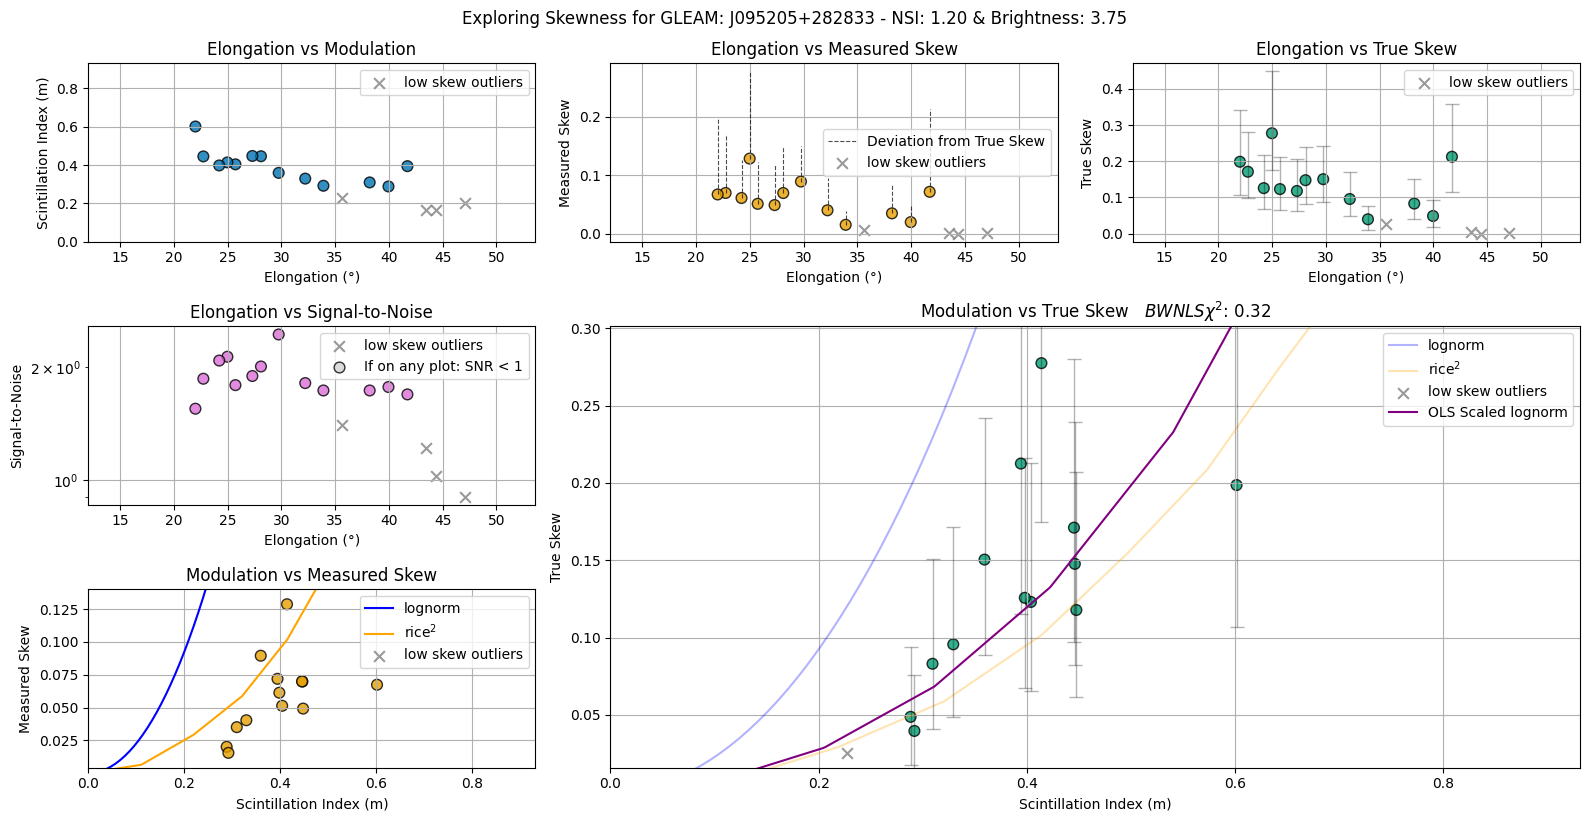

Dropdown(description='NSI - GLEAM:', options=('1.20 - J095205+282833', '1.13 - J013023+260806', '1.12 - J11505…

Dropdown(description='NSI - GLEAM:', options=('1.20 - J095205+282833', '1.13 - J013023+260806', '1.12 - J11505…

In [82]:
# Combine nsi_fit and GLEAM for the dropdown options, sorted by nsi_fit
gleam = ThreeTrue_filt['GLEAM'].copy()
nsi_fit = ThreeTrue_filt['nsi_fit'].copy()
gleam_nsi_combined = [
    (f"{nsi:.2f} - {gleam}", nsi) for gleam, nsi in zip(gleam, nsi_fit)
]

gleam_nsi_unique = sorted(set(gleam_nsi_combined), key=lambda x: x[1], reverse= True)  # Ensure uniqueness and sort by nsi_fit

# Create the Dropdown widget with combined nsi_fit and GLEAM
w3 = widgets.Dropdown(
    options=[option[0] for option in gleam_nsi_unique],  # Show nsi_fit - GLEAM in the dropdown
    value=gleam_nsi_unique[0][0],  # Default value (first nsi_fit - GLEAM)
    description='NSI - GLEAM:',
    style={'description_width': 'initial'}  # Adjust label width
)


#
# Function to plot with dropdown change and get the selected GLEAM and nsi_fit
def on_value_change3(change):
    selected_combined = change['new']
    
    # Parse the selected nsi_fit and GLEAM from the dropdown value
    selected_nsi, selected_gleam = selected_combined.split(" - ")
    tolerance = 1e-2
    selected_group = ThreeTrue_filt[
        (ThreeTrue_filt['GLEAM'] == selected_gleam) & 
        (np.isclose(ThreeTrue_filt['nsi_fit'], float(selected_nsi), atol=tolerance))
    ]
    selected_small_skews = small_skews_table[(small_skews_table['GLEAM'] == selected_gleam) & 
        (np.isclose(small_skews_table['nsi_fit'], float(selected_nsi), atol=tolerance))
    ]
    
    # Clear the previous plots
    clear_output(wait=True)  

    fig = plt.figure(figsize=(16, 8))

    # Define the grid layout
    gs = GridSpec(3, 3, figure=fig)  # A 3x3 grid
    plt.rcParams.update({
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
    })

    # Define the smaller top row plots
    ax_top1 = fig.add_subplot(gs[0, 0:1])  # First plot in the top row (spans 1 column)
    ax_top2 = fig.add_subplot(gs[0, 1:2])  # Second plot in the top row (spans 1 column)
    ax_top3 = fig.add_subplot(gs[0, 2:3])  # Third plot in the top row (spans 1 column)

    # Define the left column plots
    ax_left1 = fig.add_subplot(gs[1:2, 0:1])  # First vertical plot (left column, spans 2 rows)
    ax_left2 = fig.add_subplot(gs[2:3, 0:1])  # Second vertical plot (left column, spans 2 rows)

    # Define the large plot
    ax_large = fig.add_subplot(gs[1:, 1:])  # Large plot spans rows 1-3 and columns 2-3

    
    # Set axis limits for plotting
    skew_min = selected_group['meas_skew*'].min()
    skew_max = selected_group['meas_skew*'].max()
    margin = 0.1 * (skew_max - skew_min)  # 10% of the range

    tskew_min = selected_group['median true skew*'].min()
    tskew_max = selected_group['median true skew*'].max()
    tmargin = 0.1 * (tskew_max - tskew_min)  # 10% of the range

    # Create lognorm and rice**2 curve
    lognorm_mean_to_var_ratio, lognorm_skew_squared = lognorm_curve(mod_max)
    rice2_mean_to_var_ratio, rice2_skew_squared = rice2_curve()


    # Define colors for each plot
    colours = ['#0072B2', '#E69F00', '#009E73', 'orchid']
    colSNR0 = ['lightgray' if snr < 1 else colours[0] for snr in selected_group['SNR_source*']]
    colSNR1 = ['lightgray' if snr < 1 else colours[1] for snr in selected_group['SNR_source*']]
    colSNR2 = ['lightgray' if snr < 1 else colours[2] for snr in selected_group['SNR_source*']]
    colSNR3 = ['lightgray' if snr < 1 else colours[3] for snr in selected_group['SNR_source*']]

# Plot 1: Elongation2 vs Modulation*
    ax_top1.scatter(selected_group['elongation2'], selected_group['Modulation*'], c=colSNR0, s=60, 
                    edgecolors="black", alpha=0.8)
    
    # Regression line in Plot 1
    # slope, intercept = np.polyfit(selected_group['elongation2'], selected_group['Modulation*'], 1)
    # regression_line = slope * selected_group['elongation2'] + intercept
    # ax_top1.plot(selected_group['elongation2'], regression_line, color='red')

    # Add data points from small_skews_table as grey crosses
    ax_top1.scatter(selected_small_skews['elongation2'], selected_small_skews['Modulation*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')
    
    ax_top1.set_xlabel('Elongation (\u00B0)')
    ax_top1.set_ylabel('Scintillation Index (m)')
    ax_top1.set_title('Elongation vs Modulation')
    ax_top1.set_xlim((elon_min, elon_max))
    ax_top1.set_ylim((mod_min, mod_max))
    ax_top1.legend()
    ax_top1.grid(True)
    

# Plot 2: Elongation2 vs Meas_Skew*
    ax_top2.scatter(selected_group['elongation2'], selected_group['meas_skew*'], c=colSNR1, s=60, 
                    edgecolors="black", alpha=0.8)
    
    # deviation from measured skew to true skew
    for x, y1, y2 in zip(selected_group['elongation2'], selected_group['meas_skew*'], selected_group['median true skew*']):
        ax_top2.plot([x, x], [y1, y2], color='black', linestyle='--', linewidth=0.8, alpha=0.7)

    # Add a dummy line for the legend
    ax_top2.plot([], [], color='black', linestyle='--', linewidth=0.8, alpha=0.7, label='Deviation from True Skew')

    #regression line in Plot 2
    # slope, intercept = np.polyfit(selected_group['elongation2'], selected_group['meas_skew*'], 1)
    # regression_line = slope * selected_group['elongation2'] + intercept
    # ax_top2.plot(selected_group['elongation2'], regression_line, color='red')

    # Add data points from small_skews_table as grey crosses
    ax_top2.scatter(selected_small_skews['elongation2'], selected_small_skews['meas_skew*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')

    ax_top2.set_xlabel('Elongation (\u00B0)')
    ax_top2.set_ylabel('Measured Skew')
    ax_top2.set_title('Elongation vs Measured Skew')
    ax_top2.legend()
    ax_top2.set_xlim((elon_min, elon_max))
    ax_top2.grid(True)


# Plot 3: Elongation2 vs True Skew
    ax_top3.scatter(selected_group['elongation2'], selected_group['median true skew*'], c=colSNR2, s=60, 
                    edgecolors="black", alpha=0.8)
    
    #error bars
    ax_top3.errorbar(selected_group['elongation2'], selected_group['median true skew*'], 
        yerr=[selected_group['lower skew error*'], selected_group['upper skew error*']],
        fmt='', linestyle= '',color='black', capsize=5, elinewidth=1, markersize=6,       
        alpha=0.3)
    
    #regression line in Plot 3
    # slope, intercept = np.polyfit(selected_group['elongation2'], selected_group['median true skew*'], 1)
    # regression_line = slope * selected_group['elongation2'] + intercept
    # ax_top3.plot(selected_group['elongation2'], regression_line, color='red')

    # Add data points from small_skews_table as grey crosses
    ax_top3.scatter(selected_small_skews['elongation2'], selected_small_skews['median true skew*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')

    ax_top3.set_xlabel('Elongation (\u00B0)')
    ax_top3.set_ylabel('True Skew')
    ax_top3.set_title('Elongation vs True Skew')
    ax_top3.set_xlim((elon_min, elon_max))
    ax_top3.legend()
    ax_top3.grid(True)


# Plot 4: Elongation2 vs SNR_Source*
    ax_left1.scatter(selected_group['elongation2'], selected_group['SNR_source*'], c=colSNR3, s=60, 
                    edgecolors="black", alpha=0.8)
    ax_left1.semilogy()

    # Add data points from small_skews_table as grey crosses
    ax_left1.scatter(selected_small_skews['elongation2'], selected_small_skews['SNR_source*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')

    ax_left1.set_xlabel('Elongation (\u00B0)')
    ax_left1.set_ylabel('Signal-to-Noise')
    ax_left1.set_title('Elongation vs Signal-to-Noise')
    ax_left1.scatter([], [], c='lightgray', s=60, edgecolors="black", alpha=0.8, label='If on any plot: SNR < 1')
    ax_left1.set_xlim((elon_min, elon_max))
    ax_left1.legend()
    ax_left1.grid(True)


# Plot 5: Meas_Skew* vs Modulation*
    ax_left2.plot(lognorm_mean_to_var_ratio, lognorm_skew_squared, label='lognorm', color="blue")
    ax_left2.plot(rice2_mean_to_var_ratio, rice2_skew_squared, label='rice$^2$', color="orange")

    ax_left2.scatter(selected_group['Modulation*'], selected_group['meas_skew*'], c=colSNR1, s=60, 
                    edgecolors="black", alpha=0.8)
    
    # Add data points from small_skews_table as grey crosses
    ax_left2.scatter(selected_small_skews['elongation2'], selected_small_skews['meas_skew*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')
    
    ax_left2.set_xlabel('Scintillation Index (m)')
    ax_left2.set_ylabel('Measured Skew')
    ax_left2.set_title('Modulation vs Measured Skew')
    ax_left2.set_ylim((skew_min - margin, skew_max + margin))
    ax_left2.set_xlim((mod_min, mod_max))
    ax_left2.legend()
    ax_left2.grid(True)


# Plot 6: True_Skew* vs Modulation*
    ax_large.plot(lognorm_mean_to_var_ratio, lognorm_skew_squared, label='lognorm', color="blue", alpha=0.3)
    ax_large.plot(rice2_mean_to_var_ratio, rice2_skew_squared, label='rice$^2$', color="orange", alpha=0.3)

    ax_large.scatter(selected_group['Modulation*'], selected_group['median true skew*'], c=colSNR2, s=60, 
                    edgecolors="black", alpha=0.8)

    # Add data points from small_skews_table as grey crosses
    ax_large.scatter(selected_small_skews['Modulation*'], selected_small_skews['median true skew*'], color='grey', 
        marker='x', s=60, alpha=0.8, label='low skew outliers')
    
    #error bars
    ax_large.errorbar(selected_group['Modulation*'], selected_group['median true skew*'], 
        yerr=[selected_group['lower skew error*'], selected_group['upper skew error*']],
        fmt='', linestyle= '', color='black', capsize=5, elinewidth=1, markersize=6, alpha=0.3,)
    
    # create purple line of best fit using OLS curve fit - extended so it goes beyond highest point and to 0
    extended_modulation = np.linspace(0.01, np.max(selected_group['Modulation*'])+1, 1000)
    extended_scaled_curve = fitted_lognorm_curve(extended_modulation, selected_group['OLS scaled variable p.s*'][0])
    ax_large.plot(extended_modulation, extended_scaled_curve, label=f'OLS Scaled lognorm', color='purple')

    # # create pink line of best fit using BWNLS curve fit - extended so it goes beyond highest point and to 0
    # extended_scaled_curve = fitted_lognorm_curve(extended_modulation, selected_group['BWNLS scaled curve ps*'][0])
    # ax_large.plot(extended_modulation, extended_scaled_curve, label=f'BWLNS Scaled lognorm $\chi^2$: {selected_group['Barlows chisq vs BWNLS ps*'][0]:.2f}', color='pink')    
    
    ax_large.set_xlabel('Scintillation Index (m)')
    ax_large.set_ylabel('True Skew')
    ax_large.set_title(f'Modulation vs True Skew   $BWNLS \chi^2$: {selected_group['Barlows chisq vs BWNLS ps*'][0]:.2f}')
    ax_large.grid(True)
    ax_large.set_ylim((tskew_min - tmargin, tskew_max + tmargin))
    ax_large.set_xlim((mod_min, mod_max))
    ax_large.legend()

    # Adjust layout and display
    fig.tight_layout()
    plt.suptitle(f'Exploring Skewness for GLEAM: {selected_gleam} - NSI: {selected_group['nsi_fit'][0]:.2f} & Brightness: {selected_group['s_162'][0]:.2f}', y=1.02)
    plt.show()
    
    # print(selected_group['GLEAM'])
    

    # Add back the widget (after clearing)
    display(w3)

# Attach the function to the dropdown widget's value change event
w3.observe(on_value_change3, names='value')

# Call the function to show the initial plots
on_value_change3({'new': w3.value})

# Display the widget
display(w3)


In [83]:
# If you have source name but not nsi_fit - use this to find nsi as plots above are in nsi order
# ThreeTrue_filt[ThreeTrue_filt['GLEAM'] == 'J050535+285648']['nsi_fit'][0]

## Finalise Source Table & Observation Table

In [84]:
ThreeTrue_filt[:3]

GLEAM,obsid,meas_skew*,SNR_source*,lower true skew*,median true skew*,upper true skew*,Modulation*,elongation2,peak_flux,nsi1,mpt1,nsi_fit,s_162,closest SNR*,lower sigma*,med sigma*,upper sigma*,classic_skew*,lower skew error*,upper skew error*,OLS scaled variable p.s*,OLS std error p.s*,BWNLS scaled curve ps*,BWNLS param error ps*,Barlows chisq vs BWNLS ps*,Barlows Individual chisq vs BWNLS*
str14,int64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
J000106-174125,1233472808,0.016806185245513916,1.40234375,0.019907501900021794,0.06384836027100985,0.13226871014858935,0.1552976667881012,39.131214,0.60092515,0.6655634045600891,0.23333263397216797,0.84610957,1.2137686,1.4,0.23469723098576864,0.16575988281925041,0.09358237719634804,0.25927734375,0.04394085837098805,0.0684203498775795,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.09819870142080764
J000106-174125,1233990840,0.04833342134952545,1.8310546875,0.060396668174842294,0.11551399052504024,0.2048718872124012,0.16417242586612701,33.783356,0.90061134,0.5745881795883179,0.28572189807891846,0.84610957,1.2137686,1.8,0.2873060514093413,0.22019497102643285,0.1613543117437038,0.439697265625,0.05511732235019795,0.08935789668736097,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.6643155822837685
J000106-174125,1234768248,0.10104203224182129,2.779296875,0.09079697271175872,0.14956551568843496,0.23394228342961082,0.2970174252986908,26.298372,0.8460366,0.7227177023887634,0.4109729528427124,0.84610957,1.2137686,3.0,0.30506080445256284,0.2485714526212129,0.19637637539025446,0.6357421875,0.05876854297667623,0.08437676774117586,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.010007455970532333


### Create Source Table

In [85]:
# Group data by source
ThreeTrue_filt_grouped = ThreeTrue_filt.group_by('GLEAM')

# Table for data per source
Source_Table = Table()

# Column data lists: 
GLEAM_col = []
nsi_fit_col = []
s_162_col = []
OLS_scale_variable_col = []
OLS_std_error_col = []
BWNLS_scale_variable_col = []
BWNLS_param_error_col = []
BWNLS_chi_sq_col = []

# All observations have the same value in these columns
for source in ThreeTrue_filt_grouped.groups:
    GLEAM_col.append(source['GLEAM'][0])
    nsi_fit_col.append(source['nsi_fit'][0])
    s_162_col.append(source['s_162'][0])
    OLS_scale_variable_col.append(source['OLS scaled variable p.s*'][0])
    OLS_std_error_col.append(source['OLS std error p.s*'][0])
    BWNLS_scale_variable_col.append(source['BWNLS scaled curve ps*'][0])
    BWNLS_param_error_col.append(source['BWNLS param error ps*'][0])
    BWNLS_chi_sq_col.append(source['Barlows chisq vs BWNLS ps*'][0])
    

# Add columns to table
add_table_col(Source_Table, 'GLEAM', GLEAM_col, 'radio source name')
add_table_col(Source_Table, 'nsi_fit', nsi_fit_col, 'NSI fit parameter')
add_table_col(Source_Table, 's_162', s_162_col, 'Flux density at 162 MHz')
add_table_col(Source_Table, 'OLS_scale_variable', OLS_scale_variable_col, 'OLS scale variable')
add_table_col(Source_Table, 'OLS_std_error', OLS_std_error_col, 'OLS standard error')
add_table_col(Source_Table, 'BWNLS_scale_variable', BWNLS_scale_variable_col, 'BWNLS scale variable')
add_table_col(Source_Table, 'BWNLS_param_error', BWNLS_param_error_col, 'BWNLS parameter error')
add_table_col(Source_Table, 'BWNLS_chi_sq', BWNLS_chi_sq_col, 'BWNLS chi-squared value')


In [86]:
Source_Table[:3]


GLEAM,nsi_fit,s_162,OLS_scale_variable,OLS_std_error,BWNLS_scale_variable,BWNLS_param_error,BWNLS_chi_sq
str14,float32,float32,float64[1],float64,float64,float64,float64
J000106-174125,0.84610957,1.2137686,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903
J000130+110137,0.7925612,3.3309119,0.8929007414866128,0.3667844870769171,0.8501383013806695,0.0814879208982649,0.6018232298620322
J000559-061143,0.6078642,2.0147405,1.0450468756201874,0.1606693536462337,0.7521254274596787,0.07094401785885956,0.6694979674916424


In [87]:
len(Source_Table)

616

### Create Observations Table


In [88]:
Obs_Table = ThreeTrue_filt

In [89]:
Obs_Table[:3]

GLEAM,obsid,meas_skew*,SNR_source*,lower true skew*,median true skew*,upper true skew*,Modulation*,elongation2,peak_flux,nsi1,mpt1,nsi_fit,s_162,closest SNR*,lower sigma*,med sigma*,upper sigma*,classic_skew*,lower skew error*,upper skew error*,OLS scaled variable p.s*,OLS std error p.s*,BWNLS scaled curve ps*,BWNLS param error ps*,Barlows chisq vs BWNLS ps*,Barlows Individual chisq vs BWNLS*
str14,int64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
J000106-174125,1233472808,0.016806185245513916,1.40234375,0.019907501900021794,0.06384836027100985,0.13226871014858935,0.1552976667881012,39.131214,0.60092515,0.6655634045600891,0.23333263397216797,0.84610957,1.2137686,1.4,0.23469723098576864,0.16575988281925041,0.09358237719634804,0.25927734375,0.04394085837098805,0.0684203498775795,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.09819870142080764
J000106-174125,1233990840,0.04833342134952545,1.8310546875,0.060396668174842294,0.11551399052504024,0.2048718872124012,0.16417242586612701,33.783356,0.90061134,0.5745881795883179,0.28572189807891846,0.84610957,1.2137686,1.8,0.2873060514093413,0.22019497102643285,0.1613543117437038,0.439697265625,0.05511732235019795,0.08935789668736097,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.6643155822837685
J000106-174125,1234768248,0.10104203224182129,2.779296875,0.09079697271175872,0.14956551568843496,0.23394228342961082,0.2970174252986908,26.298372,0.8460366,0.7227177023887634,0.4109729528427124,0.84610957,1.2137686,3.0,0.30506080445256284,0.2485714526212129,0.19637637539025446,0.6357421875,0.05876854297667623,0.08437676774117586,0.8383382520522474,0.06902357857884343,0.7312257332592645,0.09484095040487224,0.20705019023907903,0.010007455970532333


In [90]:
len(Obs_Table)

15135

## APPENDICES

In [91]:
len(lognormal_lookup_Table)

697

## SNR influence on skew

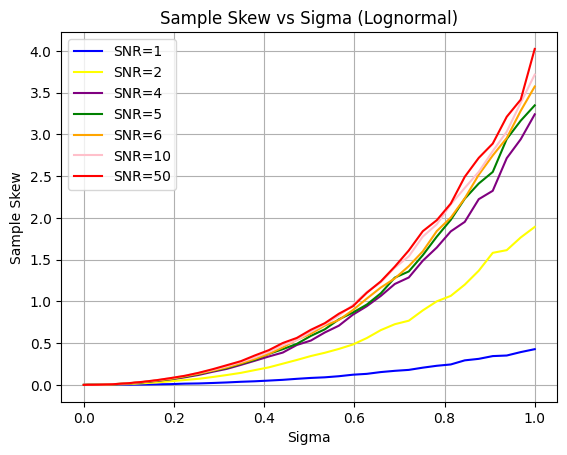

In [92]:
snr_1_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 1.0]
snr_2_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 2.0]
snr_4_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 4.0]
snr_5_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 5.0]
snr_6_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 6.0]
snr_10_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 10]
snr_50_rows = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == 50]

# Plot the Sample Skew column 
plt.plot(snr_1_rows['sigma'], snr_1_rows['sample_skew_med'], linestyle='-', color='blue', label='SNR=1')
plt.plot(snr_2_rows['sigma'], snr_2_rows['sample_skew_med'], linestyle='-', color='yellow', label='SNR=2')
plt.plot(snr_4_rows['sigma'], snr_4_rows['sample_skew_med'], linestyle='-', color='purple', label='SNR=4')
plt.plot(snr_5_rows['sigma'], snr_5_rows['sample_skew_med'], linestyle='-', color='green', label='SNR=5')
plt.plot(snr_6_rows['sigma'], snr_6_rows['sample_skew_med'], linestyle='-', color='orange', label='SNR=6')
plt.plot(snr_10_rows['sigma'], snr_10_rows['sample_skew_med'], linestyle='-', color='pink', label='SNR=10')
plt.plot(snr_50_rows['sigma'], snr_50_rows['sample_skew_med'], linestyle='-', color='red', label='SNR=50')
plt.xlabel('Sigma')
plt.ylabel('Sample Skew')
plt.title('Sample Skew vs Sigma (Lognormal)')
plt.legend()
plt.grid(True)
plt.show()

### SNR to Sigma Confidence Intervals

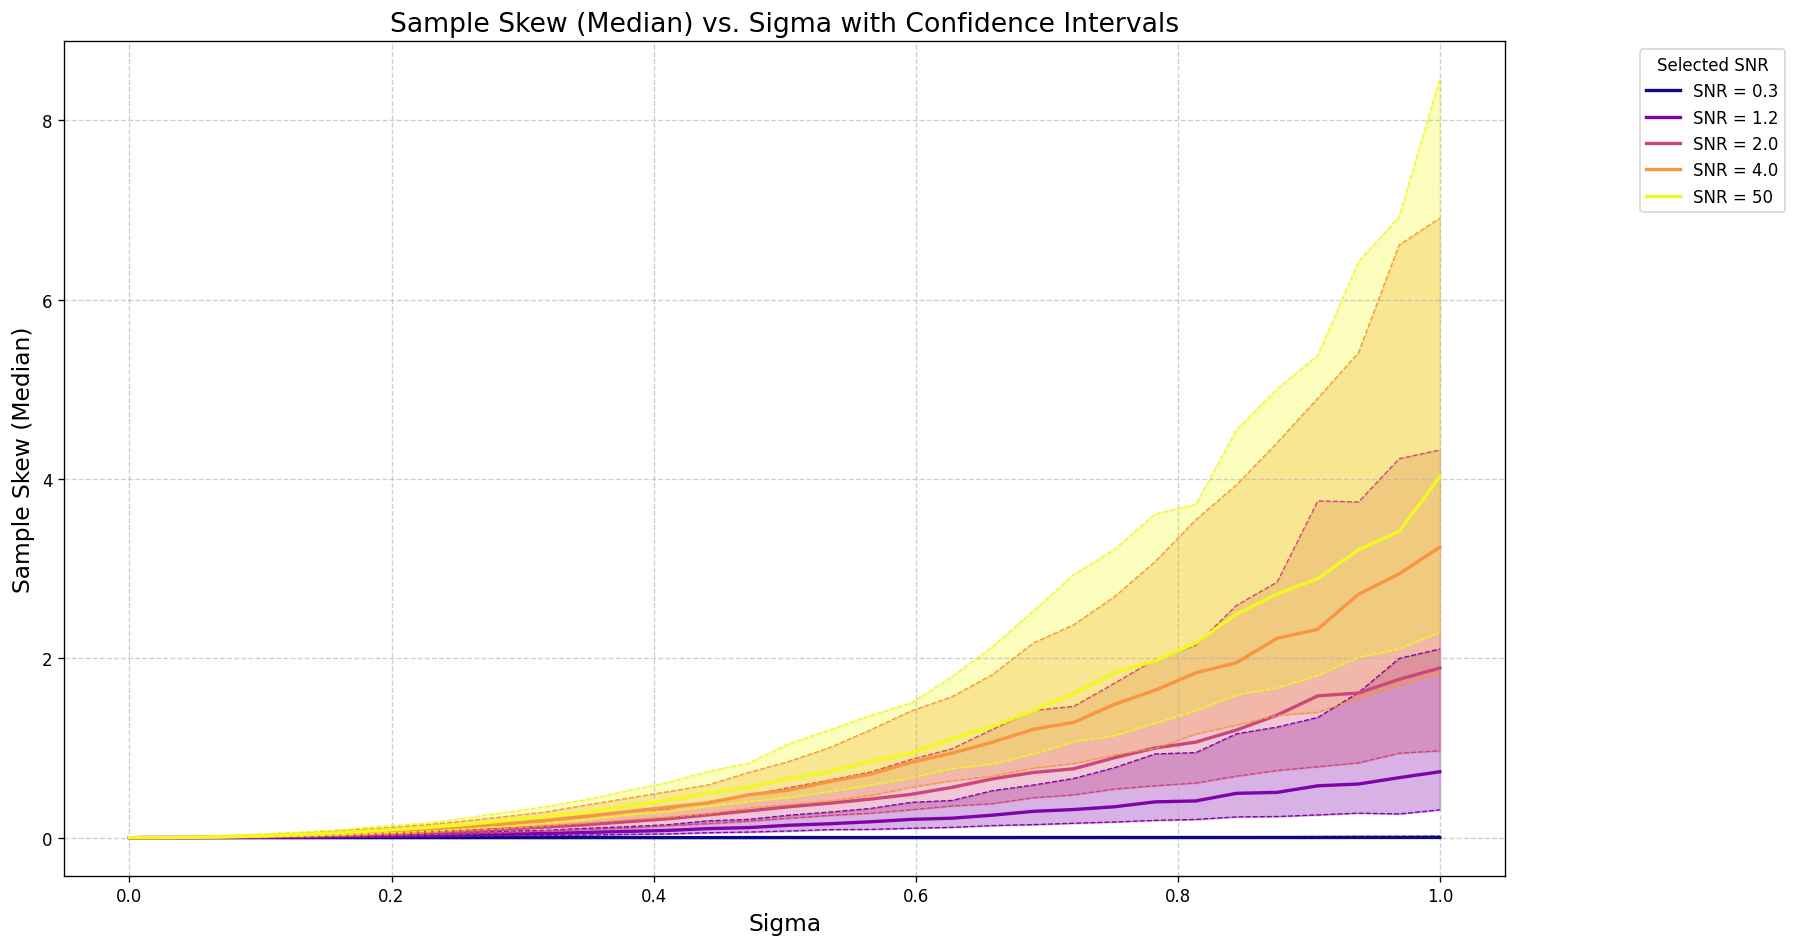

In [93]:
# Select every 3rd SNR for plotting
selected_SN_ratios = SN_ratios[::4]

# Create a colormap for SNR groups
cmap = plt.get_cmap('plasma')  # You can try 'viridis', 'plasma', or other colormaps
colors = cmap(np.linspace(0, 1, len(selected_SN_ratios)))

# Group the data by SNR
grouped_data = {}
for snr in SN_ratios:
    grouped_data[snr] = lognormal_lookup_Table[lognormal_lookup_Table['SNR'] == snr]

# Create the plot
plt.figure(figsize=(15, 8), dpi=120)
# plt.semilogy()

# Iterate through each SNR group to plot the lines and confidence intervals
for idx, snr in enumerate(selected_SN_ratios):
    group = grouped_data[snr]
    sigma_values = group['sigma']
    meas_skew_med_values = group['sample_skew_med']
    meas_skew_lower_values = group['sample_skew_lower']
    meas_skew_upper_values = group['sample_skew_upper']
    
    color = colors[idx]  # Assign a unique color to each SNR
    
    # Plot the median line
    plt.plot(
        sigma_values, meas_skew_med_values, 
        label=f'SNR = {snr}', color=color, linewidth=2
    )
    
    # Plot the confidence interval
    plt.fill_between(
        sigma_values, 
        meas_skew_lower_values, 
        meas_skew_upper_values, 
        color=color, alpha=0.3  # Slightly transparent shading
    )

        # Add black lines for the upper and lower bounds
    plt.plot(sigma_values, meas_skew_lower_values, color=color, linestyle='--', linewidth=0.8)
    plt.plot(sigma_values, meas_skew_upper_values, color=color, linestyle='--', linewidth=0.8)

# Customize the plot
plt.title('Sample Skew (Median) vs. Sigma with Confidence Intervals', fontsize=16)
plt.xlabel('Sigma', fontsize=14)
plt.ylabel('Sample Skew (Median)', fontsize=14)
plt.legend(title='Selected SNR', fontsize=10, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# Error Bars for Sigma vs Measured Skew

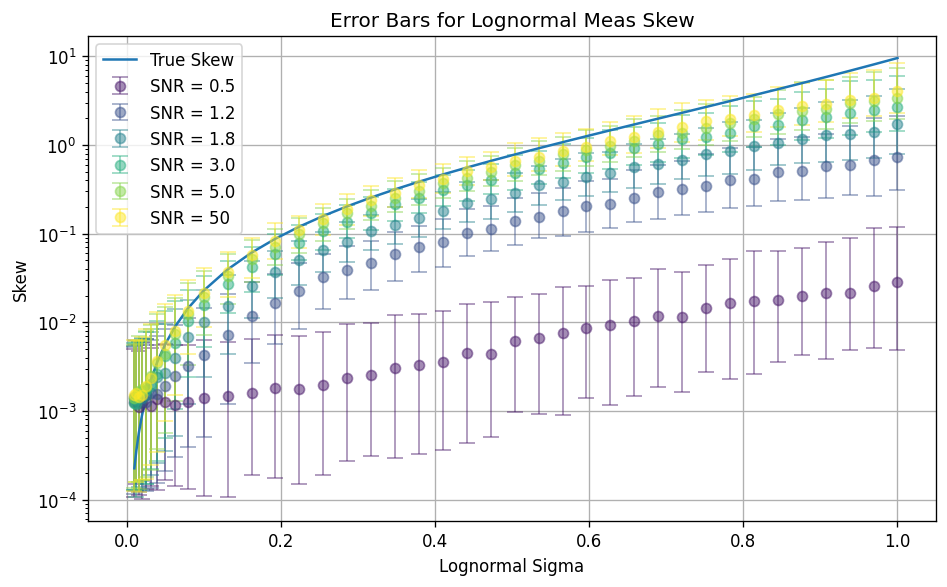

In [94]:
# Assign colours for each SNR
cmap = plt.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, len(SN_ratios)))

# Create a new figure for each SNR
# fig, ax = plt.subplots(9, 2, figsize=(20, 20), dpi=180)
# ax = ax.flatten()

# Loop through each SNR and create a separate plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.semilogy()

for idx, snr in enumerate(SN_ratios):
    snrcolour = colours[idx]

    # Collect all rows that match snr
    rows_for_snr = [row for row in lognormal_lookup_Table if row['SNR'] == snr]

    # Empty lists
    sigmas = []
    lower_errors = []
    upper_errors = []
    if idx==0:
        true_skew = []

    # put all sigmas from relevant rows into lists
    for r, row in enumerate(rows_for_snr):
        sigmas.append(row['sigma'])
        if idx==0:
            true_skew.append(lognorm.stats(row['sigma'], moments='s')**2/4)
        
        #calculate errors for each row and put into lists
        lower_err = row['sample_skew_med'] - row['sample_skew_lower']  # Lower bound (50% - 5%)
        upper_err = row['sample_skew_upper'] - row['sample_skew_med']  # Upper bound (95% - 50%)
        lower_errors.append(lower_err)
        upper_errors.append(upper_err)
    
        if (idx+2)%3==0:
            
            ax.errorbar(row['sigma'], row['sample_skew_med'], 
                        yerr=[[lower_err], [upper_err]], 
                        fmt='o', color=snrcolour, 
                        label=f'SNR = {snr}' if r == 0 else "",  # Only label the first plot for each SNR
                        capsize=5, elinewidth=1, markersize=6, alpha=0.5)

ax.plot(sigmas, true_skew, label="True Skew")
# Customize the subplot for this SNR
ax.set_title(f'Error Bars for Lognormal Meas Skew')
ax.grid(True)
# Set y-axis limits 
# ax[idx].set_ylim([-5, high95+5])

ax.set_xlabel('Lognormal Sigma')
ax.set_ylabel('Skew')
ax.legend()


fig.tight_layout()
#plt.show()

### Plot of Sigma Values

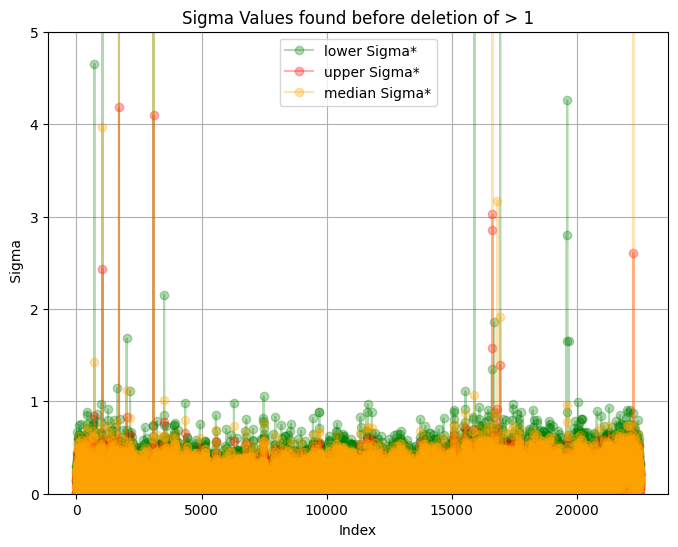

1. Total observations: 22516
2. Count of rows where 'lower sigma*' is greater than 1: 18
3. Count of rows where 'med sigma*' is greater than 1: 13
4. Count of rows where 'upper sigma*' is greater than 1: 8


In [95]:
# Plotting lower sigma* directly using the column index
plt.figure(figsize=(8, 6))

plt.plot(
    range(len(sigma_found_before_del['lower sigma*'])),  # Use a range for the x-axis
    sigma_found_before_del['lower sigma*'], 
    marker='o', linestyle='-', color='green', label='lower Sigma*', alpha=0.3
)

plt.plot(
    range(len(sigma_found_before_del['upper sigma*'])),  # Use a range for the x-axis
    sigma_found_before_del['upper sigma*'], 
    marker='o', linestyle='-', color='red', label='upper Sigma*', alpha=0.3
)

plt.plot(
    range(len(sigma_found_before_del['med sigma*'])),  # Use a range for the x-axis
    sigma_found_before_del['med sigma*'], 
    marker='o', linestyle='-', color='orange', label='median Sigma*', alpha=0.3
)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel(' Sigma')
plt.title('Sigma Values found before deletion of > 1')

plt.ylim(0, 5)
# Add grid and legend
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

lower_sigma_above_1 = sum(sigma_found_before_del['lower sigma*'] > 1)
med_sigma_above_1 = sum(sigma_found_before_del['med sigma*'] > 1)
upper_sigma_above_1 = sum(sigma_found_before_del['upper sigma*'] > 1)

print(f"1. Total observations: {len(sigma_found_before_del)}")
print(f"2. Count of rows where 'lower sigma*' is greater than 1: {lower_sigma_above_1}")
print(f"3. Count of rows where 'med sigma*' is greater than 1: {med_sigma_above_1}")
print(f"4. Count of rows where 'upper sigma*' is greater than 1: {upper_sigma_above_1}")



### Small Skew Monte Carlo
Placebo test: Monte Carlo Gaussian measurements
Determine throw away fraction of skews

0.1066651286663814 0.2133302573327628


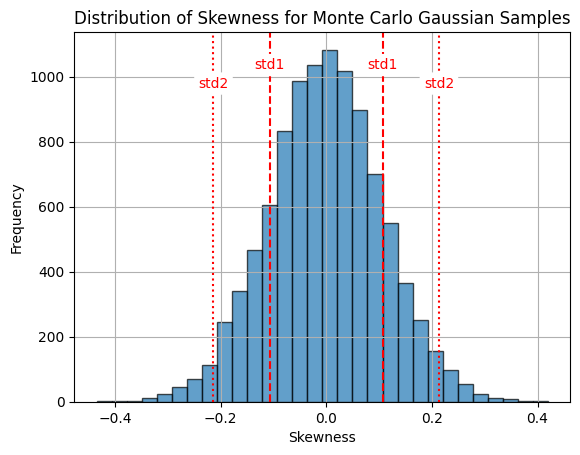

In [96]:
#Monte Carlo samples and draws
n_samples = 520 # Number of samples 
n_draws = 10000  # Number of Monte Carlo draws

# Generate Monte Carlo gaussian samples (520 samples, 1000 Monte Carlo draws)
gauss_samples = np.random.normal(0, size=(n_samples, n_draws))
skew_samples = skew(gauss_samples, axis=0)

std1 = np.std(skew_samples)
std2 = 2* std1
print(std1, std2)
# print(skew_samples)

fig, axes = plt.subplots()
axes.hist(skew_samples, bins=30, edgecolor='black', alpha=0.7)
# Add red lines for standard deviations
axes.axvline(x=std1, color='red', linestyle='--', label='1 Std Dev')
axes.axvline(x=-(std1), color='red', linestyle='--', label='1 Std Dev')
axes.axvline(x=std2, color='red', linestyle=':', label='2 Std Dev')
axes.axvline(x=-(std2), color='red', linestyle=':', label='2 Std Dev')

# Add labels at the lines
axes.text(std1, axes.get_ylim()[1] * 0.9, "std1", color='red', ha='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
axes.text(-std1, axes.get_ylim()[1] * 0.9, "std1", color='red', ha='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
axes.text(std2, axes.get_ylim()[1] * 0.85, "std2", color='red', ha='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
axes.text(-std2, axes.get_ylim()[1] * 0.85, "std2", color='red', ha='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

axes.set_title("Distribution of Skewness for Monte Carlo Gaussian Samples")
axes.set_xlabel("Skewness")
axes.set_ylabel("Frequency")
plt.grid(True)
plt.show()

### Chi Sq Histogram

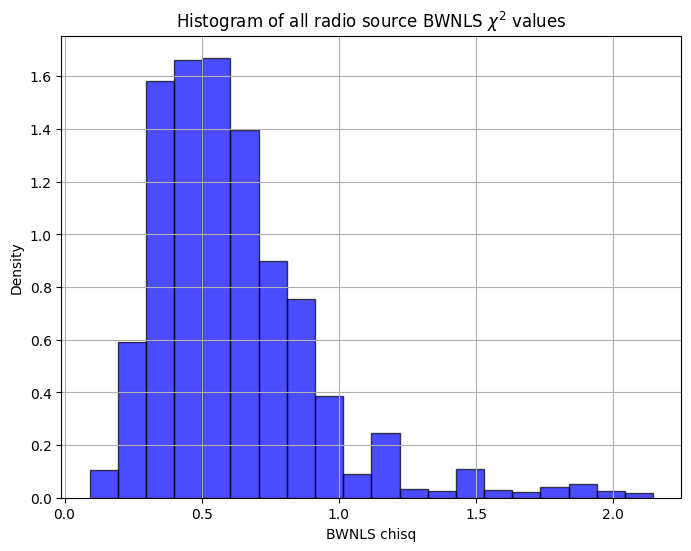

In [97]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(Obs_Table['Barlows chisq vs BWNLS ps*'], bins=20, color='blue', alpha=0.7, edgecolor='black', density=True)

# Add labels and title
plt.xlabel('BWNLS chisq')
plt.ylabel('Density')
plt.title('Histogram of all radio source BWNLS $\chi^2$ values')
plt.grid(True)

# Show the plot
plt.show()

### NSI vs Barlows Scaled Variable (coloured by parameter errors)

In [98]:
#  Determine common color scale limits
vmin = min(Source_Table['BWNLS_param_error'])
vmax = max(Source_Table['BWNLS_param_error'])

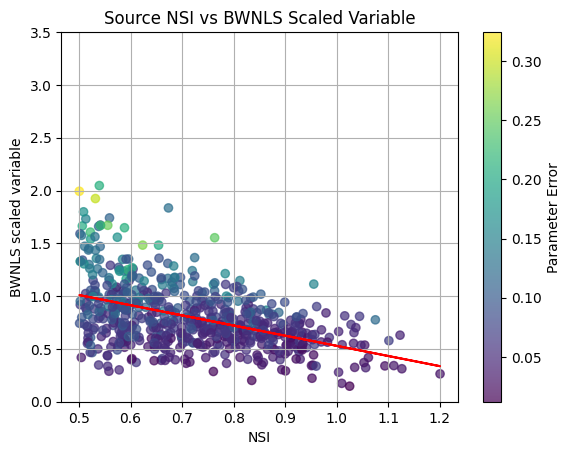

In [99]:
fig, axes = plt.subplots()
scatter = axes.scatter(Source_Table['nsi_fit'], Source_Table['BWNLS_scale_variable'], c=Source_Table['BWNLS_param_error'], cmap='viridis',
                       alpha=0.7, vmin=vmin, vmax=vmax) #norm=LogNorm(vmin=min(param_errors), vmax=max(param_errors))
cbar = plt.colorbar(scatter, ax=axes)

# Calculate the regression line
y = Source_Table['BWNLS_scale_variable']
slope, intercept, r_value, p_value, std_err = stats.linregress(Source_Table['nsi_fit'], y)
regression_line = slope * Source_Table['nsi_fit'] + intercept

# Plot the regression line
axes.plot(Source_Table['nsi_fit'], regression_line, color='red', label='Regression Line')


cbar.set_label('Parameter Error')
axes.set_ylim(0, 3.5)
axes.set_xlabel('NSI')
axes.set_ylabel('BWNLS scaled variable')
axes.set_title(f'Source NSI vs BWNLS Scaled Variable')
axes.grid(True)
plt.show()

### NSI vs OLS Scaled Variable (coloured by standard errors)

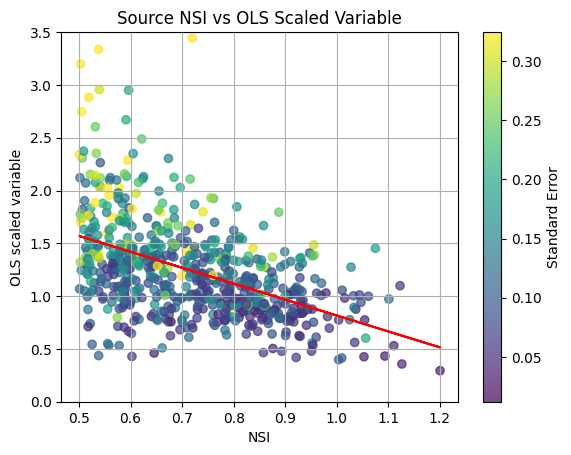

In [100]:
fig, axes = plt.subplots()
scatter = axes.scatter(Source_Table['nsi_fit'], Source_Table['OLS_scale_variable'], c=Source_Table['OLS_std_error'], cmap='viridis',
                       alpha=0.7, vmin=vmin, vmax=vmax) #norm=LogNorm(vmin=min(param_errors), vmax=max(param_errors))
cbar = plt.colorbar(scatter, ax=axes)

# Calculate the regression line
y = Source_Table['OLS_scale_variable'][:, 0]
slope, intercept, r_value, p_value, std_err = stats.linregress(Source_Table['nsi_fit'], y)
regression_line = slope * Source_Table['nsi_fit'] + intercept

# Plot the regression line
axes.plot(Source_Table['nsi_fit'], regression_line, color='red', label='Regression Line')

cbar.set_label('Standard Error')
axes.set_ylim(0, 3.5)
axes.set_xlabel('NSI')
axes.set_ylabel('OLS scaled variable')
axes.set_title(f'Source NSI vs OLS Scaled Variable')
axes.grid(True)
plt.show()

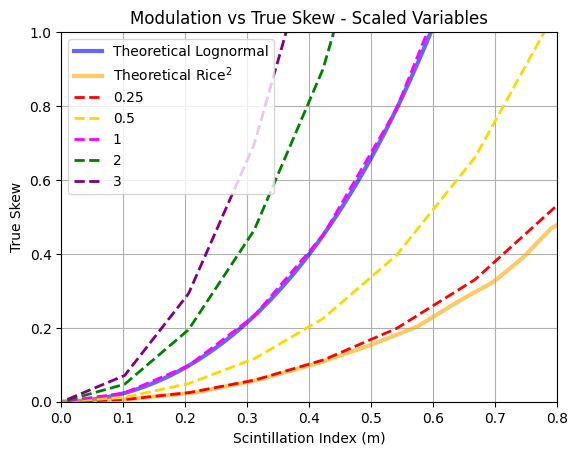

In [101]:
fig, axes = plt.subplots()
axes.plot(lognorm_mean_to_var_ratio, lognorm_skew_squared, label='Theoretical Lognormal', color="blue", linewidth=3, alpha=0.6)
axes.plot(rice2_mean_to_var_ratio, rice2_skew_squared, label='Theoretical Rice$^2$', color="orange", linewidth=3, alpha=0.6)

curve_list = [0.25, 0.5, 1, 2, 3]
linecol = ['red', 'gold', 'fuchsia', 'green', 'purple']

for i, scaled_var in enumerate(curve_list):
    extended_modulation = np.linspace(0.01, np.max(ThreeTrue_filt['Modulation*'])+1, 1000)
    extended_scaled_curve = fitted_lognorm_curve(extended_modulation, scaled_var)
    axes.plot(extended_modulation, extended_scaled_curve, label=f'{scaled_var}', color=linecol[i], linestyle='--', linewidth=2)


axes.set_xlabel('Scintillation Index (m)')
axes.set_ylabel('True Skew')
axes.set_title(f'Modulation vs True Skew - Scaled Variables')
axes.grid(True)
axes.set_ylim((0, 1))
axes.set_xlim((0, 0.8))
axes.legend()